<a href="https://colab.research.google.com/github/peachvegetable/STA314-project/blob/master/Exercise3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Gymnasium API
!pip -q install gymnasium[classic-control]==0.29.1

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

#setup
SEED    = 123
ENV_ID  = "CartPole-v1"
GAMMA   = 0.995
SOLVED  = 470          #mean of 100 episodes >= 475 as solved
MA_WIN  = 30           #moving average window for curves

#discretization
BINS    = (12, 12, 24, 30)   # (x, x_dot, theta, theta_dot)
CLIP_LO = np.array([-4.8, -3.0, -0.418, -3.5], dtype=np.float32)
CLIP_HI = np.array([ 4.8,  3.0,  0.418,  3.5], dtype=np.float32)

def _build_bins(lo, hi, k):
    return np.linspace(lo, hi, k + 1)[1:-1]

BIN_EDGES = [
    _build_bins(CLIP_LO[0], CLIP_HI[0], BINS[0]),
    _build_bins(CLIP_LO[1], CLIP_HI[1], BINS[1]),
    _build_bins(CLIP_LO[2], CLIP_HI[2], BINS[2]),
    _build_bins(CLIP_LO[3], CLIP_HI[3], BINS[3]),
]

def discretize(obs):
    o = np.clip(np.asarray(obs, np.float32), CLIP_LO, CLIP_HI)
    idxs = [np.digitize(o[i], BIN_EDGES[i]) for i in range(4)]
    s = idxs[0]
    for i in range(1, 4):
        s = s * BINS[i] + idxs[i]
    return int(s)

def make_env():
    return gym.make(ENV_ID)

def lin_sched(v0, v1, t, T):
    if T <= 1: return v1
    f = t/(T-1)
    return (1-f)*v0 + f*v1

#ε-greedy policy
def epsilon_greedy(Q, s, eps, nA, rng):
    if rng.random() < eps:
        return int(rng.integers(nA))
    qs = Q[s]
    m = np.max(qs)
    cand = np.flatnonzero(np.abs(qs - m) < 1e-8)
    return int(rng.choice(cand))

#Expected SARSA target
def expected_q_next(Q, s_next, eps):
    qs = Q[s_next]
    a_star = int(np.argmax(qs))
    greedy = qs[a_star]
    mean_q = float(qs.mean())
    return (1 - eps) * greedy + eps * mean_q

#greedy evaluation
def greedy_eval(Q, episodes=100, seed_base=999):
    env = make_env()
    scores = []
    for k in range(episodes):
        obs, info = env.reset(seed=seed_base + k)
        s = discretize(obs); done = False; G = 0
        while not done:
            a = int(np.argmax(Q[s]))
            obs, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            s = discretize(obs)
            G += r
        scores.append(G)
    env.close()
    return np.array(scores, dtype=np.float32)


[SARSA] episode 200. | MA= 36.97 | alpha=0.532 | epsilon=0.15
[SARSA] episode 400. | MA= 98.70 | alpha=0.514 | epsilon=0.15
[SARSA] episode 600. | MA=122.00 | alpha=0.496 | epsilon=0.15
[SARSA] episode 800. | MA=148.03 | alpha=0.478 | epsilon=0.15
[SARSA] episode 1000. | MA=266.37 | alpha=0.460 | epsilon=0.15
[SARSA] episode 1200. | MA=207.57 | alpha=0.442 | epsilon=0.15
[SARSA] episode 1400. | MA=278.77 | alpha=0.424 | epsilon=0.15
[SARSA] episode 1600. | MA=211.60 | alpha=0.406 | epsilon=0.15
[SARSA] episode 1800. | MA=181.87 | alpha=0.387 | epsilon=0.15
[SARSA] episode 2000. | MA=294.83 | alpha=0.369 | epsilon=0.15
[SARSA] episode 2200. | MA=244.23 | alpha=0.351 | epsilon=0.15
[SARSA] episode 2400. | MA=303.23 | alpha=0.333 | epsilon=0.15
[SARSA] episode 2600. | MA=328.33 | alpha=0.315 | epsilon=0.15
[SARSA] episode 2800. | MA=371.97 | alpha=0.297 | epsilon=0.15
[SARSA] episode 3000. | MA=318.07 | alpha=0.279 | epsilon=0.15
[SARSA] episode 3200. | MA=303.80 | alpha=0.261 | epsilon=0

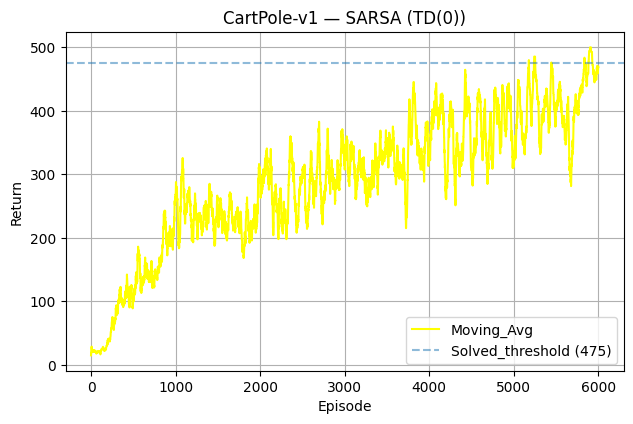

In [ ]:
# On-policy SARSA (TD(0))
import numpy as np, matplotlib.pyplot as plt

EPISODES     = 6000
ALPHA_START  = 0.55
ALPHA_END    = 0.008
EPS_START    = 0.15
EPS_END      = 0.15
EPS_DECAY    = False

#build environment, empty Q-table
rng = np.random.default_rng(SEED)
env = make_env()
nA  = env.action_space.n
nS  = int(np.prod(BINS))
Q_sarsa = np.zeros((nS, nA), dtype=np.float32)

returns, mavg = [], []

for ep in range(EPISODES):
    alpha = lin_sched(ALPHA_START, ALPHA_END, ep, EPISODES)
    eps   = lin_sched(EPS_START, EPS_END, ep, EPISODES) if EPS_DECAY else EPS_START

    obs, info = env.reset(seed=SEED + ep)
    s = discretize(obs)
    a = epsilon_greedy(Q_sarsa, s, eps, nA, rng)

    done, G = False, 0.0
    while not done:
        obs_next, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        s_next = discretize(obs_next)

        # SARSA target
        a_next = epsilon_greedy(Q_sarsa, s_next, eps, nA, rng)
        td_target = r + (0.0 if done else GAMMA * Q_sarsa[s_next, a_next])
        Q_sarsa[s, a] += alpha * (td_target - Q_sarsa[s, a])

        s, a = s_next, a_next
        G += r
#record,print,colse environment after training
    returns.append(G)
    m = np.mean(returns[-MA_WIN:]) if len(returns)>=MA_WIN else np.mean(returns)
    mavg.append(m)
    if (ep+1) % 200 == 0:
        print(f"[SARSA] episode {ep+1}. | MA={m:6.2f} | alpha={alpha:.3f} | epsilon={eps:.2f}")

env.close()

#greedy evaluation
scores = greedy_eval(Q_sarsa, episodes=100)
print("\n=== SARSA — Greedy Eval (100) ===")
print(f"Mean={scores.mean():.2f} | Std={scores.std():.2f} | Max={scores.max():.0f}")

#moving-average curve
plt.figure(figsize=(7.2,4.4))
plt.plot(mavg, color="yellow", label="Moving_Avg")
plt.axhline(475, ls="--", alpha=0.5, label="Solved_threshold (475)")
plt.title("CartPole-v1 — SARSA (TD(0))")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend(); plt.show()

res_sarsa = {"Q": Q_sarsa, "returns": returns, "moving_avg": mavg, "eval_scores": scores}




[Expected SARSA] episode 200. | MA= 60.53 | alpha=0.5870 | epsilon=0.220
[Expected SARSA] episode 400. | MA=167.00 | alpha=0.5739 | epsilon=0.220
[Expected SARSA] episode 600. | MA=192.83 | alpha=0.5608 | epsilon=0.220
[Expected SARSA] episode 800. | MA=198.50 | alpha=0.5477 | epsilon=0.220
[Expected SARSA] episode 1000. | MA=238.37 | alpha=0.5346 | epsilon=0.220
[Expected SARSA] episode 1200. | MA=244.23 | alpha=0.5215 | epsilon=0.220
[Expected SARSA] episode 1400. | MA=298.63 | alpha=0.5084 | epsilon=0.220
[Expected SARSA] episode 1600. | MA=280.93 | alpha=0.4953 | epsilon=0.220
[Expected SARSA] episode 1800. | MA=326.57 | alpha=0.4822 | epsilon=0.220
[Expected SARSA] episode 2000. | MA=336.50 | alpha=0.4691 | epsilon=0.220
[Expected SARSA] episode 2200. | MA=371.57 | alpha=0.4560 | epsilon=0.220
[Expected SARSA] episode 2400. | MA=260.47 | alpha=0.4429 | epsilon=0.220
[Expected SARSA] episode 2600. | MA=326.77 | alpha=0.4298 | epsilon=0.220
[Expected SARSA] episode 2800. | MA=358.27

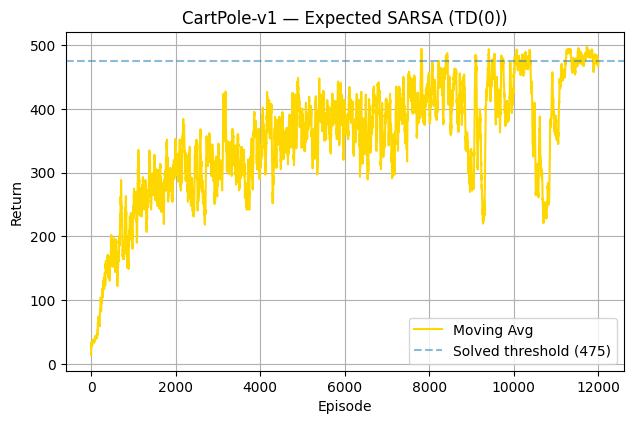

In [ ]:
#Off-policy Expected SARSA (TD(0))
import numpy as np, matplotlib.pyplot as plt


EPISODES = 12000
GAMMA    = 0.995

#Split training, first 70% decays alpha from 0.6 to 0.05, last 30% from 0.05 to 0.0015.
ALPHA_START_1, ALPHA_END_1 = 0.60, 0.05
ALPHA_START_2, ALPHA_END_2 = 0.05, 0.0015
SPLIT_FRAC = 0.70
def alpha_sched(ep, T):
    cut = int(SPLIT_FRAC * T)
    if ep < cut:
        f = ep / max(1, cut-1)
        return (1-f)*ALPHA_START_1 + f*ALPHA_END_1
    f = (ep - cut) / max(1, T-cut-1)
    return (1-f)*ALPHA_START_2 + f*ALPHA_END_2

#Keep strong exploration (epsilon = 0.22) for the first 60%, then anneal to 0.01
#hold at 0.01 for the last 5% to converge.
HOLD_FRAC, FINAL_FRAC = 0.55, 0.05
EPS_HOLD, EPS_FINAL   = 0.22, 0.01
def eps_sched(ep, T):
    hold = int(HOLD_FRAC * T)
    last = int((1 - FINAL_FRAC) * T)
    if ep < hold:
        return EPS_HOLD
    if ep < last:
        f = (ep - hold) / max(1, last - hold)
        return (1-f)*EPS_HOLD + f*EPS_FINAL
    return EPS_FINAL

rng = np.random.default_rng(SEED)
env = make_env()
nA  = env.action_space.n
nS  = int(np.prod(BINS))

#optimistic initialization
Q_es = np.full((nS, nA), 1.8, dtype=np.float32)

returns, mavg = [], []

for ep in range(EPISODES):
    alpha = alpha_sched(ep, EPISODES)
    eps   = eps_sched(ep, EPISODES)

    obs, info = env.reset(seed=SEED + ep)
    s = discretize(obs)

    done, G = False, 0.0
    while not done:
        a = epsilon_greedy(Q_es, s, eps, nA, rng)

        obs_next, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        s_next = discretize(obs_next)

        # Expected SARSA target：E_{a'~ε-greedy}[Q(s', a')]
        exp_q = 0.0 if done else expected_q_next(Q_es, s_next, eps)
        td_target = r + GAMMA * exp_q
        Q_es[s, a] += alpha * (td_target - Q_es[s, a])

        s = s_next
        G += r

    returns.append(G)
    m = np.mean(returns[-MA_WIN:]) if len(returns) >= MA_WIN else np.mean(returns)
    mavg.append(m)
    if (ep + 1) % 200 == 0:
        print(f"[Expected SARSA] episode {ep+1}. | MA={m:6.2f} | alpha={alpha:.4f} | epsilon={eps:.3f}")

env.close()

#greedy evaluation
scores = greedy_eval(Q_es, episodes=100)
print("\n=== Expected SARSA — Greedy Eval (100) ===")
print(f"Mean={scores.mean():.2f} | Std={scores.std():.2f} | Max={scores.max():.0f}")

#moving-average curve
plt.figure(figsize=(7.2,4.4))
plt.plot(mavg, color="yellow", label="Moving Avg")
plt.axhline(475, ls="--", alpha=0.5, label="Solved threshold (475)")
plt.title("CartPole-v1 — Expected SARSA (TD(0))")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend(); plt.show()

res_expected_sarsa = {"Q": Q_es, "returns": returns, "moving_avg": mavg, "eval_scores": scores}



[Q-learning] episode 200. | MA= 54.43 | alpha=0.536 | epsilon=0.200
[Q-learning] episode 400. | MA=186.87 | alpha=0.521 | epsilon=0.200
[Q-learning] episode 600. | MA=202.20 | alpha=0.507 | epsilon=0.200
[Q-learning] episode 800. | MA=209.10 | alpha=0.493 | epsilon=0.200
[Q-learning] episode 1000. | MA=197.40 | alpha=0.479 | epsilon=0.200
[Q-learning] episode 1200. | MA=172.60 | alpha=0.464 | epsilon=0.200
[Q-learning] episode 1400. | MA=245.20 | alpha=0.450 | epsilon=0.200
[Q-learning] episode 1600. | MA=196.73 | alpha=0.436 | epsilon=0.200
[Q-learning] episode 1800. | MA=263.93 | alpha=0.421 | epsilon=0.200
[Q-learning] episode 2000. | MA=352.33 | alpha=0.407 | epsilon=0.200
[Q-learning] episode 2200. | MA=228.43 | alpha=0.393 | epsilon=0.200
[Q-learning] episode 2400. | MA=261.37 | alpha=0.379 | epsilon=0.200
[Q-learning] episode 2600. | MA=275.93 | alpha=0.364 | epsilon=0.200
[Q-learning] episode 2800. | MA=269.00 | alpha=0.350 | epsilon=0.200
[Q-learning] episode 3000. | MA=264.50

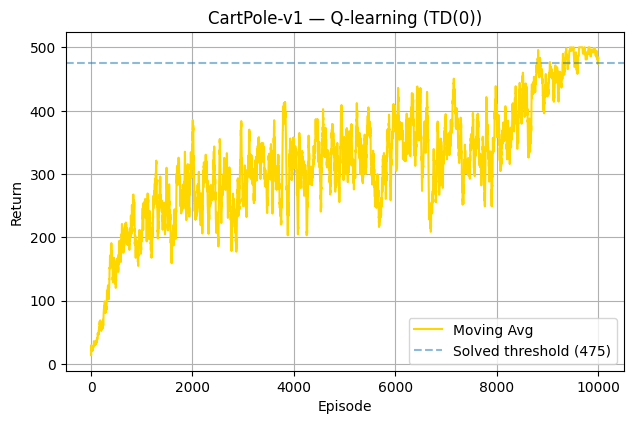

In [ ]:
#Off-policy Q-learning (TD(0))
import numpy as np, matplotlib.pyplot as plt

EPISODES = 10000
GAMMA    = 0.995

#Split training，first 70% decays alpha from 0.55 to 0.05, last 30% from 0.05 to 0.002.
ALPHA_START_1, ALPHA_END_1 = 0.55, 0.05
ALPHA_START_2, ALPHA_END_2 = 0.05, 0.002
SPLIT_FRAC = 0.70
def alpha_sched(ep, T):
    cut = int(SPLIT_FRAC * T)
    if ep < cut:
        f = ep / max(1, cut-1)
        return (1-f)*ALPHA_START_1 + f*ALPHA_END_1
    f = (ep - cut) / max(1, T-cut-1)
    return (1-f)*ALPHA_START_2 + f*ALPHA_END_2

#Keep strong exploration (epsilon = 0.2) for the first 60%, then anneal to 0.01
#hold at 0.01 for the last 5% to converge.
HOLD_FRAC, FINAL_FRAC = 0.60, 0.05
EPS_HOLD, EPS_FINAL = 0.20, 0.01
def eps_sched(ep, T):
    hold = int(HOLD_FRAC * T)
    last = int((1 - FINAL_FRAC) * T)
    if ep < hold:
        return EPS_HOLD
    if ep < last:
        f = (ep - hold) / max(1, last - hold)
        return (1-f)*EPS_HOLD + f*EPS_FINAL
    return EPS_FINAL

rng = np.random.default_rng(SEED)
env = make_env()
nA  = env.action_space.n
nS  = int(np.prod(BINS))

#optimistic initialization
Q_ql = np.full((nS, nA), 2.0, dtype=np.float32)

returns, mavg = [], []

for ep in range(EPISODES):
    alpha = alpha_sched(ep, EPISODES)
    eps   = eps_sched(ep, EPISODES)

    obs, info = env.reset(seed=SEED + ep)
    s = discretize(obs)

    done, G = False, 0.0
    while not done:
        a = epsilon_greedy(Q_ql, s, eps, nA, rng)
        obs_next, r, terminated, truncated, info = env.step(a)
        done = terminated or truncated
        s_next = discretize(obs_next)

        # Q-learning target max_a' Q(s', a')
        td_target = r + (0.0 if done else GAMMA * np.max(Q_ql[s_next]))
        Q_ql[s, a] += alpha * (td_target - Q_ql[s, a])

        s = s_next
        G += r

    returns.append(G)
    m = np.mean(returns[-MA_WIN:]) if len(returns) >= MA_WIN else np.mean(returns)
    mavg.append(m)
    if (ep + 1) % 200 == 0:
        print(f"[Q-learning] episode {ep+1}. | MA={m:6.2f} | alpha={alpha:.3f} | epsilon={eps:.3f}")

env.close()

#greedy evaluation
scores = greedy_eval(Q_ql, episodes=100)
print("\n=== Q-learning — Greedy Eval (100) ===")
print(f"Mean={scores.mean():.2f} | Std={scores.std():.2f} | Max={scores.max():.0f}")

#moving-average curve
plt.figure(figsize=(7.2,4.4))
plt.plot(mavg, color="gold", label="Moving Avg")
plt.axhline(475, ls="--", alpha=0.5, label="Solved threshold (475)")
plt.title("CartPole-v1 — Q-learning (TD(0))")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.grid(True); plt.legend(); plt.show()

res_qlearning = {"Q": Q_ql, "returns": returns, "moving_avg": mavg, "eval_scores": scores}



##Reference
https://gymnasium.farama.org/environments/classic_control/cart_pole/


https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html

https://www.gatsby.ucl.ac.uk/~dayan/papers/cjch.pdf

https://python.plainenglish.io/understanding-q-learning-the-original-smart-algorithm-961ac29c4cb7


